In [1]:
'''
3d inverted pendulum implemented with sympy
'''

import sympy as sp
from sympy.physics.mechanics import dynamicsymbols

In [ ]:
# define symbols
t = sp.symbols('t')
g = sp.symbols('g')
m = sp.symbols('m')
l = sp.symbols('l')
# action
f_x, f_y = sp.symbols('f_x f_y')
# dynamic symbols
u, v = dynamicsymbols('u v')
# other variables
theta = sp.sqrt(u**2 + v**2)
phi = sp.atan2(v, u)
x = l * sp.sin(theta) * sp.cos(phi)
y = l * sp.sin(theta) * sp.sin(phi)
z = l * sp.cos(theta)
f_rope=  sp.symbols('f_rope')

In [ ]:
x_dot = x.diff(t)
y_dot = y.diff(t)
z_dot = z.diff(t)
x_ddot = x_dot.diff(t)
y_ddot = y_dot.diff(t)
z_ddot = z_dot.diff(t)

In [ ]:
x_ddot

In [ ]:
# Newton's equation
eq_x = f_x + f_rope_x - m * x_ddot
eq_y = f_y + f_rope_y - m * y_ddot
eq_z = -m * g + f_rope_z - m * z_ddot

In [3]:
x1, x2, x3 = dynamicsymbols('x1 x2 x3')
t = sp.symbols('t')
(x1**2 + x2**2 + x3**2).diff(t,1)

2*x1(t)*Derivative(x1(t), t) + 2*x2(t)*Derivative(x2(t), t) + 2*x3(t)*Derivative(x3(t), t)

In [1]:
import numpy as np

# Quaternion functions
def hat(v):
    return np.array([[0, -v[2], v[1]],
                     [v[2], 0, -v[0]],
                     [-v[1], v[0], 0]])

def L(q):
    '''
    L(q) = [s, -v; v^T, sI + hat(v)]
    left multiplication matrix of a quaternion
    '''
    s = q[0]
    v = q[1:4]
    upper = np.hstack((s, -v))
    lower_left = v.reshape(-1, 1)
    lower_right = s * np.eye(3) + hat(v)
    lower = np.hstack((lower_left, lower_right))
    return np.vstack((upper, lower))


def qtoQ(q):
    '''
    covert a quaternion to a 3x3 rotation matrix
    '''
    T = np.diag([1, -1, -1, -1])
    H = np.vstack((np.zeros((1, 3)), np.eye(3))) # used to convert a 3d vector to 4d vector
    Lq = L(q)
    return H.T @ T @ Lq @ T @ Lq @ H

# Test
q = np.array([1, 0, 1, 0])
print(qtoQ(q))

[[ 0.  0.  2.]
 [ 0.  2.  0.]
 [-2.  0.  0.]]


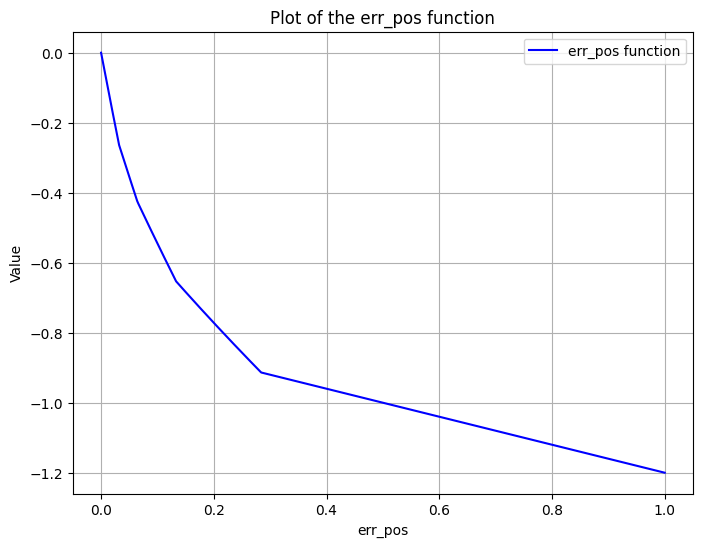

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax

# Define the function
def err_pos(err_pos):
    return -err_pos * 0.4 - \
           jnp.clip(jnp.log(err_pos + 1) * 4, 0, 1) * 0.4 - \
           jnp.clip(jnp.log(err_pos + 1) * 8, 0, 1) * 0.2 - \
           jnp.clip(jnp.log(err_pos + 1) * 16, 0, 1) * 0.1 - \
           jnp.clip(jnp.log(err_pos + 1) * 32, 0, 1) * 0.1

# Generate a range of values for err_pos
x = np.linspace(0, 1.0, 1000)

# Calculate the function values
y = jax.vmap(err_pos)(x)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(x, y, label='err_pos function', color='b')
plt.xlabel('err_pos')
plt.ylabel('Value')
plt.title('Plot of the err_pos function')
plt.grid(True)
plt.legend()
plt.show()
